# Unsupervised Sentiment Analysis with Sychrony Chat Data 

### Author: Li Cao, Yixiao Xiong, Xinkai Zhao

## Data Cleaning and Data Manipulation

In [59]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

import multiprocessing
from sklearn.cluster import KMeans
#from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import confusion_matrix

In [4]:
day2 = pd.read_excel('Day2.xlsx')
day4 = pd.read_excel('day4.xlsx')
day5 = pd.read_excel('day5.xlsx')
day6 = pd.read_excel('day6.xlsx')

In [5]:
df1 = pd.concat([day2, day4, day5, day6],ignore_index=True)
df1.shape

(3571711, 9)

In [6]:
dfall = df1.drop_duplicates(ignore_index=True)
dfall.shape

(2740304, 9)

In [7]:
dfall.loc[:,'DATE_TIME'] = pd.to_datetime(dfall['DATE_TIME'])
dfall.loc[:,'END_DATE_TIME'] = pd.to_datetime(dfall['END_DATE_TIME'])

E:\miniconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
E:\miniconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [8]:
dfall.isnull().sum()

DATE_TIME                0
END_DATE_TIME            0
IVA_CHAT_ID              0
CHAT_TYPE                0
CLIENT_ID                0
LOGIN_STATE              0
IVA_CHAT_REASON    1017617
INPUT               668205
RESPONSE            704314
dtype: int64

In [9]:
df = dfall[dfall['INPUT'].notna()]
df = df[df['INPUT']!='****']

In [10]:
df.loc[:,'calltime'] = df['END_DATE_TIME'] - df['DATE_TIME']
df.loc[:,'calltime'] = df['calltime'].dt.total_seconds()

In [11]:
df['CHAT_TYPE'].value_counts()

Deflected    1405296
LiveChat      647223
Error           1468
Name: CHAT_TYPE, dtype: int64

In [12]:
df = df.loc[df['CHAT_TYPE'] != 'Error']

In [13]:
df['INPUT'].isnull().sum()

0

## Descriptive Analytics

In [14]:
singlechatdf = df.drop_duplicates(subset = ['IVA_CHAT_ID'],ignore_index=True)

In [15]:
deflive = singlechatdf['CHAT_TYPE'].value_counts()*100/len(singlechatdf)
deflive

Deflected    82.343853
LiveChat     17.656147
Name: CHAT_TYPE, dtype: float64

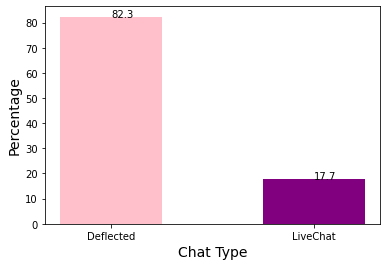

<Figure size 432x288 with 0 Axes>

In [16]:
chat_type = ['Deflected','LiveChat']
percent = [82.3,17.7]

bars = plt.bar(chat_type, percent, color=['pink','purple'], width= 0.5, align = 'center')
plt.xlabel('Chat Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.25, yval + 0.01, yval)
plt.show()
plt.savefig('chattype.png')

In [17]:
callinpercent = singlechatdf.value_counts(['CLIENT_ID'])*100/len(singlechatdf)
callinpercent.head(5)

CLIENT_ID      
Consumer Center    17.943942
Amazon             16.310748
PayPal Credit      16.247186
Lowes               9.604502
Sams                9.451335
dtype: float64

In [18]:
pie = callinpercent.reset_index()
pie.columns = ['CLIENT_ID','Percent']

pie3 = callinpercent.reset_index()
pie3.columns = ['CLIENT_ID','Percent']

pie2 = pie.iloc[0:10,]
pie2.at[9,'CLIENT_ID'] = 'Other 28 companies'
pie2.at[9,'Percent'] = 12.299713

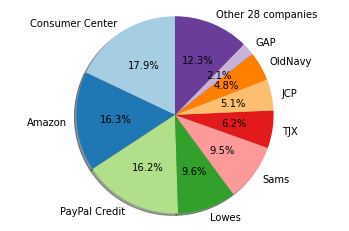

In [19]:
fig1, ax1 = plt.subplots()
ax1.pie(pie2['Percent'], labels=pie2['CLIENT_ID'], colors = sns.color_palette("Paired")[0:10], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

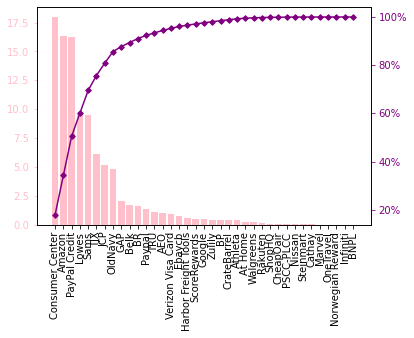

In [20]:
color1 = 'pink'
color2 = 'purple'
line_size = 4

pie3['cumperc'] = pie3['Percent'].cumsum()

fig, ax = plt.subplots()
ax.bar(pie3.index, pie3['Percent'], color=color1)

ax2 = ax.twinx()
ax2.plot(pie3.index, pie3['cumperc'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

x_pos = np.arange(len(pie3))
plt.xticks(x_pos,pie3['CLIENT_ID'])

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
#display Pareto chart

plt.show()
#fig.savefig('test3png.png')

#plt.savefig('pareto1.png')

In [21]:
clientdf = singlechatdf.groupby(['CLIENT_ID', 'CHAT_TYPE']).size()
clientdf

CLIENT_ID          CHAT_TYPE
AEO                Deflected     1996
                   LiveChat       268
Amazon             Deflected    31951
                   LiveChat      5001
At Home            Deflected      415
                                ...  
Verizon Visa Card  LiveChat       327
Walgreens          Deflected      396
                   LiveChat        49
Zulily             Deflected      892
                   LiveChat        97
Length: 71, dtype: int64

In [22]:
deflectpercent = clientdf*100/singlechatdf.groupby(['CLIENT_ID']).size()
deflectpercent

CLIENT_ID          CHAT_TYPE
AEO                Deflected    88.162544
                   LiveChat     11.837456
Amazon             Deflected    86.466226
                   LiveChat     13.533774
At Home            Deflected    88.486141
                                  ...    
Verizon Visa Card  LiveChat     16.228288
Walgreens          Deflected    88.988764
                   LiveChat     11.011236
Zulily             Deflected    90.192113
                   LiveChat      9.807887
Length: 71, dtype: float64

In [23]:
deff = deflectpercent.sort_values(ascending = False).reset_index()
deff.columns = ['CLIENT_ID', 'CHAT_TYPE','Percent']
deff

,CLIENT_ID,CHAT_TYPE,Percent
0,OneTravel,Deflected,100.000000
1,BNPL,Deflected,100.000000
2,Infiniti,Deflected,100.000000
3,Cathay,Deflected,94.285714
4,TRU,Deflected,90.978078
...,...,...,...
66,Rakuten,LiveChat,10.276680
67,Zulily,LiveChat,9.807887
68,Harbor Freight Tools,LiveChat,9.520000
69,TRU,LiveChat,9.021922


In [24]:
deff[deff['CHAT_TYPE'] == 'Deflected']

,CLIENT_ID,CHAT_TYPE,Percent
0,OneTravel,Deflected,100.000000
1,BNPL,Deflected,100.000000
2,Infiniti,Deflected,100.000000
3,Cathay,Deflected,94.285714
4,TRU,Deflected,90.978078
5,Harbor Freight Tools,Deflected,90.480000
6,Zulily,Deflected,90.192113
7,Rakuten,Deflected,89.723320
8,Belk,Deflected,89.506494
9,Walgreens,Deflected,88.988764


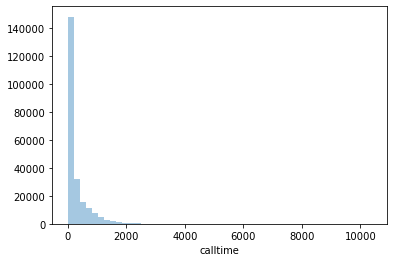

In [25]:
sns.distplot(singlechatdf['calltime'],kde=False)
plt.show()

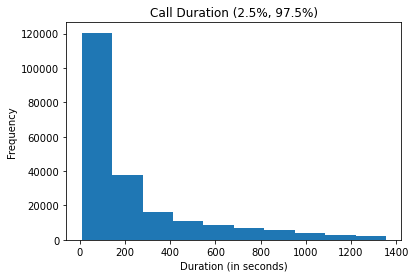

In [26]:
plt.hist(singlechatdf[(singlechatdf['calltime']<=singlechatdf['calltime'].quantile(0.975))&(singlechatdf['calltime']>=singlechatdf['calltime'].quantile(0.025))]['calltime'])
plt.xlabel('Duration (in seconds)')
plt.ylabel('Frequency')
plt.title('Call Duration (2.5%, 97.5%)')
plt.show()

In [27]:
singlechatdf['calltime'].quantile(0.025)

8.879137725000001

In [28]:
singlechatdf['calltime'].quantile(0.975)

1354.5288738249994

## Unsupervised Sentiment Analysis with KMeans Clustering

In [29]:
nltk.download('stopwords')
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [30]:
onlyinput = df.groupby(['IVA_CHAT_ID'])['INPUT'].apply(' '.join).reset_index().drop('IVA_CHAT_ID', axis=1)

In [31]:
corpus=[]

for i in range(0, len(onlyinput)):

  inp = re.sub(r'[^a-zA-Z ]+', ' ', onlyinput['INPUT'].iloc[i])
  inp = inp.lower()
  inp = inp.split()
  inp = [ps.stem(word) for word in inp if not word in set(all_stopwords)]
  inp = ' '.join(inp)
  corpus.append(inp)

In [32]:
sent = corpus.copy()
phrases = Phrases(sent)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [64]:
w2v_model = Word2Vec(min_count=8, window=6,
                     alpha=0.03, min_alpha=0.0007, 
                     workers=multiprocessing.cpu_count()-1)

w2v_model.build_vocab(sentences)

In [65]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=20)

(117096085, 701388300)

In [66]:
word_vectors = w2v_model.wv
model = KMeans(n_clusters=2).fit(X=word_vectors.vectors.astype('double'))

In [67]:
positive_cluster_center = model.cluster_centers_[1]
negative_cluster_center = model.cluster_centers_[0]

In [68]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [69]:
words['cluster_value'] = [1 if i==1 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [70]:
sentiment_map = words[['words', 'sentiment_coeff']]
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))
weights = onlyinput.copy()

## Prediction

In [71]:
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(weights.INPUT)
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(weights.INPUT)

E:\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [72]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.INPUT.lower().split()))

def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [73]:
replaced_tfidf_scores = weights.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)

replaced_closeness_scores = weights.INPUT.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [74]:
sentiment_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores]).T
sentiment_df.columns = ['sentiment_coeff', 'tfidf_scores']
sentiment_df['sentiment_rate'] = sentiment_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
sentiment_df['prediction'] = (sentiment_df.sentiment_rate>0).astype('int8')

In [75]:
sentiment_df['prediction'].value_counts()

0    132624
1     93926
Name: prediction, dtype: int64

In [184]:
final = pd.concat((singlechatdf, sentiment_df), axis=1)[['CHAT_TYPE', 'calltime', 'prediction']]
final.head()

,CHAT_TYPE,calltime,prediction
0,Deflected,13.638235,1
1,Deflected,91.914486,0
2,Deflected,22.916657,0
3,Deflected,661.647362,0
4,Deflected,88.256782,0


In [186]:
final.groupby('CHAT_TYPE')['prediction'].value_counts()

CHAT_TYPE  prediction
Deflected  0             112885
           1              73665
LiveChat   1              20261
           0              19739
Name: prediction, dtype: int64

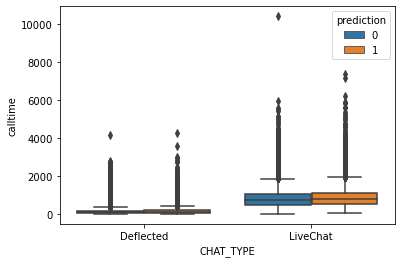

In [185]:
sns.boxplot(y="calltime",x="CHAT_TYPE",hue="prediction", data=final)
plt.show()